RCV Elections Database
    Proportional ranked choice voting CVRs
        .csv
    Sequential ranked choice voting CVRs
        .csv
    Single winner ranked choice voting CVRs
        .csv
.csv

In [3]:
import os
import pandas as pd

# Define the path to the main directory
main_dir_path = "rcv_elections_database/"

# Define the subdirectories
subdirectories = [
    "proportional",
    "sequential",
    "single"
]

# Create a list to store all dataframes
dfs = []

# Loop over all subdirectories
for subdir in subdirectories:
    subdir_path = os.path.join(main_dir_path, subdir)

    # Loop over all the CSV files in the subdirectory
    for filename in os.listdir(subdir_path):
        if filename.endswith(".csv"):
            # Read the CSV file into a DataFrame
            df = pd.read_csv(os.path.join(subdir_path, filename))
            
            # Add new columns 'source_file' and 'type' containing the name of the source CSV file and the type of the election, respectively
            df['source_file'] = filename
            df['type'] = subdir  # This will indicate the type of the election

            # Keep only columns that start with 'rank' or are 'source_file' or 'type'
            df = df[[col for col in df.columns if col.startswith('rank') or col in ['source_file', 'type']]]

            # Append the DataFrame to the list of dataframes
            dfs.append(df)

# Concatenate all dataframes in the list into a single DataFrame
cast_vote_data = pd.concat(dfs, ignore_index=True)

# Reorder the columns to move the rank columns to the end
cols_to_order = ['source_file', 'type']
new_columns = cols_to_order + (cast_vote_data.columns.drop(cols_to_order).tolist())
cast_vote_data = cast_vote_data[new_columns]

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91223/3510087131.py:25: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(subdir_path, filename))
/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91223/3510087131.py:25: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(subdir_path, filename))
/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91223/3510087131.py:25: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(subdir_path, filename))
/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91223/3510087131.py:25: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(subdir_path, filename))
/var/folders/g2/25z774tn0599smwks8_v_k200000

In [4]:
# Print the first few rows of the consolidated DataFrame
print(cast_vote_data.head())

                                         source_file          type  \
0  Minneapolis_11072017_BoardofEstimateandTaxatio...  proportional   
1  Minneapolis_11072017_BoardofEstimateandTaxatio...  proportional   
2  Minneapolis_11072017_BoardofEstimateandTaxatio...  proportional   
3  Minneapolis_11072017_BoardofEstimateandTaxatio...  proportional   
4  Minneapolis_11072017_BoardofEstimateandTaxatio...  proportional   

              rank1             rank2    rank3 rank4 rank5 rank6 rank7 rank8  \
0      Carol Becker  David B. Wheeler  skipped   NaN   NaN   NaN   NaN   NaN   
1      Carol Becker  David B. Wheeler  skipped   NaN   NaN   NaN   NaN   NaN   
2  David B. Wheeler           skipped  skipped   NaN   NaN   NaN   NaN   NaN   
3      Carol Becker           skipped  skipped   NaN   NaN   NaN   NaN   NaN   
4           skipped           skipped  skipped   NaN   NaN   NaN   NaN   NaN   

   ... rank17 rank18 rank19 rank20 rank21 rank22 rank23 rank24 rank25 rank26  
0  ...    NaN    Na

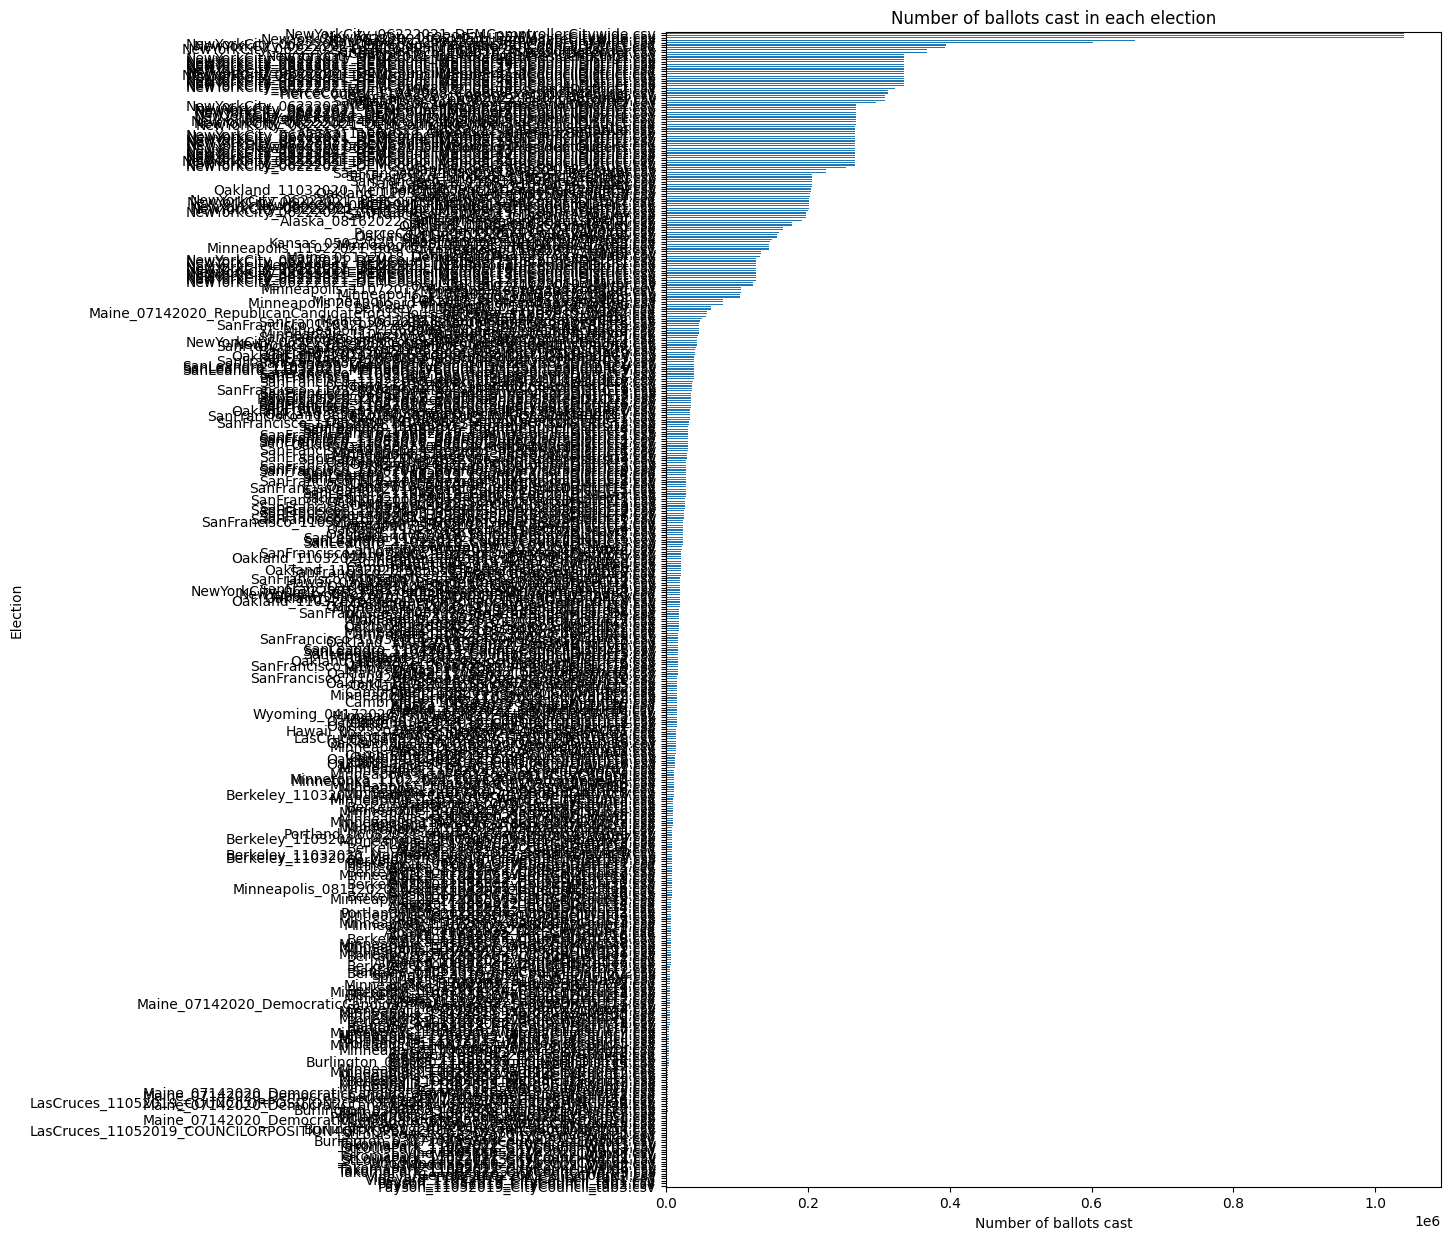

In [5]:
import matplotlib.pyplot as plt

# Count the number of ballots cast for each election
ballots_per_election = cast_vote_data['source_file'].value_counts().sort_values()

# Plot the data
plt.figure(figsize=(10, 15))
ballots_per_election.plot(kind='barh')
plt.xlabel('Number of ballots cast')
plt.ylabel('Election')
plt.title('Number of ballots cast in each election')
plt.show()

In [11]:
import requests
import json

# Census API key
api_key = '662ad2b75e57af64cf96d3e2af7c49e1d324bb7c'

# Define the base URL for the decennial census API, P4_001N is the total population over 18 years old
base_url = f'https://api.census.gov/data/2020/dec/pl?get=NAME,P3_001N&for=state:*&key={api_key}'

# Send a GET request to the API
response = requests.get(base_url)

# Print out the response text
print(response.text)

# Load the response as a JSON object
data = json.loads(response.text)

# Convert the JSON object to a DataFrame
census_data = pd.DataFrame(data[1:], columns=data[0])

# Print the first few rows of the DataFrame
print(census_data.head())

[["NAME","P3_001N","state"],
["Pennsylvania","10353548","42"],
["California","30827105","06"],
["West Virginia","1432932","54"],
["Utah","2324051","49"],
["New York","16088135","36"],
["District of Columbia","575161","11"],
["Alaska","554003","02"],
["Florida","17339232","12"],
["South Carolina","4014460","45"],
["North Dakota","596093","38"],
["Maine","1110085","23"],
["Georgia","8220274","13"],
["Alabama","3917166","01"],
["New Hampshire","1120680","33"],
["Oregon","3370652","41"],
["Wyoming","441337","56"],
["Arizona","5541976","04"],
["Louisiana","3570548","22"],
["Indiana","5192579","18"],
["Idaho","1376400","16"],
["Connecticut","2869227","09"],
["Hawaii","1155905","15"],
["Illinois","9999469","17"],
["Massachusetts","5663723","25"],
["Texas","21866700","48"],
["Montana","850123","30"],
["Nebraska","1476127","31"],
["Ohio","9207562","39"],
["Colorado","4509576","08"],
["New Jersey","7281310","34"],
["Maryland","4815202","24"],
["Virginia","6745054","51"],
["Vermont","524482","50"

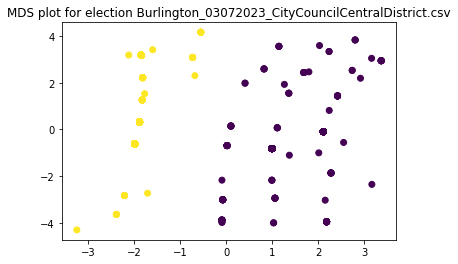

Inter-centroid distance: 3.723745123750687


In [18]:
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'Burlington_03072023_CityCouncilCentralDistrict.csv'].copy()

# Convert candidate names to numeric IDs for MDS
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform MDS
mds = MDS(n_components=2, metric=False, dissimilarity='euclidean')
mds_coordinates = mds.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(mds_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the MDS coordinates and color code them by cluster label
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'MDS plot for election Burlington_03072023_CityCouncilCentralDistrict.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

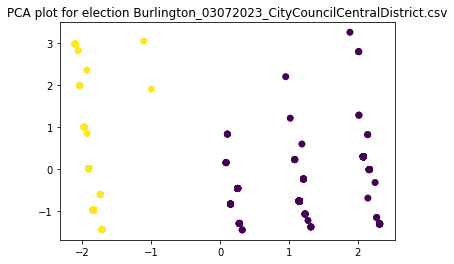

Inter-centroid distance: 3.665926472484169


In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'Burlington_03072023_CityCouncilCentralDistrict.csv'].copy()

# Convert candidate names to numeric IDs for PCA
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform PCA
pca = PCA(n_components=2)
pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(pca_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the PCA coordinates and color code them by cluster label
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'PCA plot for election Burlington_03072023_CityCouncilCentralDistrict.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

In [23]:
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np

inter_centroid_distances = []

# Number of elections to sample
n_samples = 50

# Randomly sample a subset of the elections
elections_sample = np.random.choice(cast_vote_data['source_file'].unique(), size=n_samples, replace=False)

# Iterate over the sampled elections
for election in elections_sample:
    # Filter DataFrame to include only the current election
    election_df = cast_vote_data[cast_vote_data['source_file'] == election].copy()

    # Convert candidate names to numeric IDs for MDS
    le = LabelEncoder()
    for col in election_df.columns:
        if col.startswith('rank'):
            # Handle missing values by replacing them with a placeholder
            election_df[col] = election_df[col].fillna('Missing')
            election_df[col] = le.fit_transform(election_df[col])

    # Perform MDS
    mds = MDS(n_components=2)
    mds_coordinates = mds.fit_transform(election_df.drop(columns=['source_file', 'type']))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
    kmeans.fit(pca_coordinates)

    # Compute the inter-centroid distance and store it
    centroid1, centroid2 = kmeans.cluster_centers_
    inter_centroid_distance = distance.euclidean(centroid1, centroid2)
    inter_centroid_distances.append(inter_centroid_distance)

    # Plot the MDS coordinates and color code them by cluster label
    plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=kmeans.labels_)
    plt.title(f'MDS plot for election {election}')
    plt.show()

# List of inter-centroid distances for the sampled elections, convert it to a pandas Series for easier manipulation
inter_centroid_distances = pd.Series(inter_centroid_distances, index=elections_sample)

# Reindex the inter_centroid_distances Series to match the order of the ballots_per_election Series
inter_centroid_distances = inter_centroid_distances.reindex(ballots_per_election.index)

# Plot the inter-centroid distances
inter_centroid_distances.plot(kind='barh', figsize=(10, 15))
plt.xlabel('Inter-centroid distance')
plt.ylabel('Election')
plt.title('Inter-centroid distances for each election')
plt.show()

KeyboardInterrupt: 

c:\Python310\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_18908\1293317627.py:28: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(pca_coordinates)
c:\Python310\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_18908\1293317627.py:28: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(pca_coordinates)
c:\Python310\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_varia

                                          Inter-centroid Distance
Election                                                         
TakomaPark_11082022_Mayor.csv                           89.644487
TakomaPark_11082022_CityCouncilWard2.csv                42.329640
Cambridge_11042003_CityCouncil.csv                      33.428410
Cambridge_11052013_CityCouncil.csv                      29.847442
Cambridge_11032015_CityCouncil.csv                      29.407309
...                                                           ...
Vineyard_11052019_CityCouncil_tab1.csv                   0.000000
Easthampton_11022021_Mayor.csv                           0.000000
Payson_11052019_CityCouncil_tab2.csv                     0.000000
Payson_11052019_CityCouncil_tab3.csv                     0.000000
Payson_11052019_CityCouncil_tab1.csv                     0.000000

[483 rows x 1 columns]


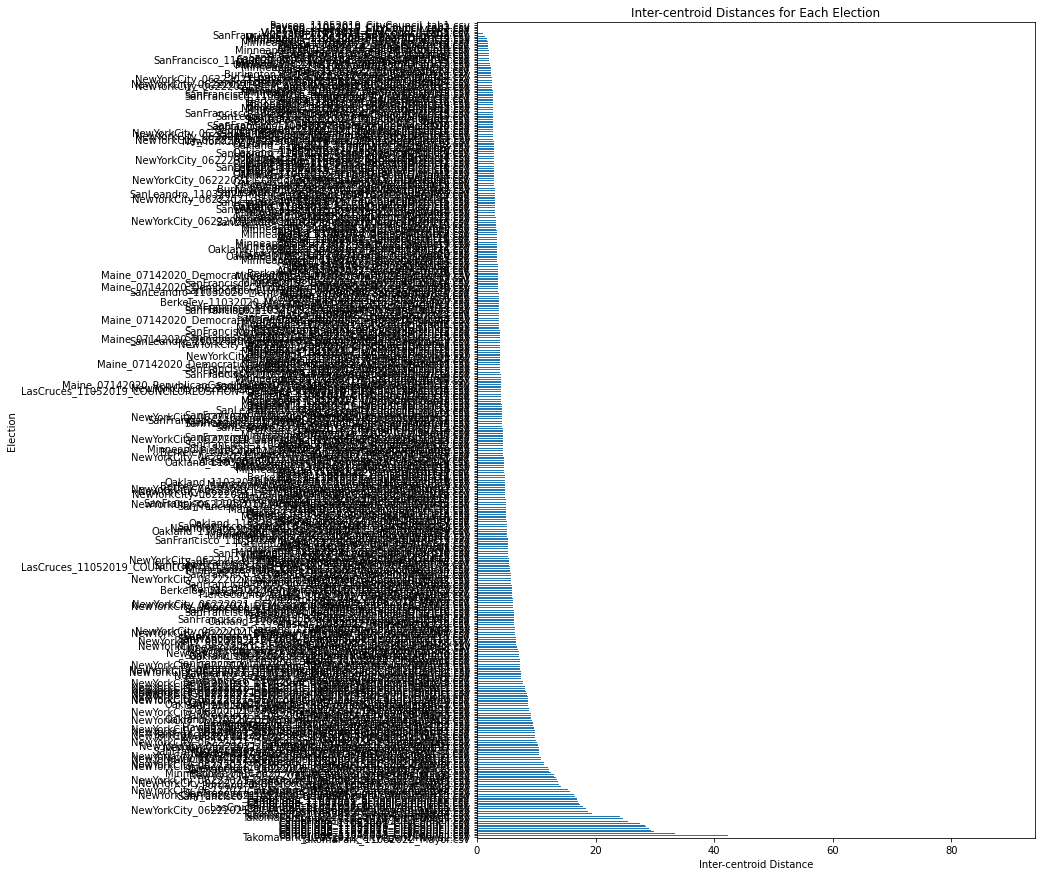

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np

inter_centroid_distances = []

# Iterate over all elections
for election in cast_vote_data['source_file'].unique():
    # Filter DataFrame to include only the current election
    election_df = cast_vote_data[cast_vote_data['source_file'] == election].copy()

    # Convert candidate names to numeric IDs for PCA
    le = LabelEncoder()
    for col in election_df.columns:
        if col.startswith('rank'):
            # Handle missing values by replacing them with a placeholder
            election_df[col] = election_df[col].fillna('Missing')
            election_df[col] = le.fit_transform(election_df[col])

    # Perform PCA
    pca = PCA(n_components=2)
    pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
    kmeans.fit(pca_coordinates)

    # Compute the inter-centroid distance and store it
    centroid1, centroid2 = kmeans.cluster_centers_
    inter_centroid_distance = distance.euclidean(centroid1, centroid2)
    inter_centroid_distances.append((election, inter_centroid_distance))

# Create a DataFrame with inter-centroid distances for all elections
inter_centroid_df = pd.DataFrame(inter_centroid_distances, columns=['Election', 'Inter-centroid Distance'])
inter_centroid_df.set_index('Election', inplace=True)

# Sort the DataFrame by inter-centroid distance in descending order
sorted_inter_centroid_df = inter_centroid_df.sort_values(by='Inter-centroid Distance', ascending=False)

# Print the DataFrame
print(sorted_inter_centroid_df)

# Plot the inter-centroid distances
sorted_inter_centroid_df.plot(kind='barh', figsize=(10, 15), legend=False)
plt.xlabel('Inter-centroid Distance')
plt.ylabel('Election')
plt.title('Inter-centroid Distances for Each Election')
plt.show()

In [27]:
# Print each row in the sorted DataFrame one by one
for idx, row in sorted_inter_centroid_df.iterrows():
    print(f"Election: {idx}, Inter-centroid Distance: {row['Inter-centroid Distance']}")

Election: TakomaPark_11082022_Mayor.csv, Inter-centroid Distance: 89.64448742153263
Election: TakomaPark_11082022_CityCouncilWard2.csv, Inter-centroid Distance: 42.32964035822397
Election: Cambridge_11042003_CityCouncil.csv, Inter-centroid Distance: 33.42841047003881
Election: Cambridge_11052013_CityCouncil.csv, Inter-centroid Distance: 29.847442227314023
Election: Cambridge_11032015_CityCouncil.csv, Inter-centroid Distance: 29.407309222974806
Election: Cambridge_11072017_CityCouncil.csv, Inter-centroid Distance: 29.10520019818051
Election: Cambridge_11082005_CityCouncil.csv, Inter-centroid Distance: 28.4999054073439
Election: Cambridge_11152019_CityCouncil.csv, Inter-centroid Distance: 28.318335562182657
Election: Cambridge_11062001_CityCouncil.csv, Inter-centroid Distance: 27.431646791608355
Election: Cambridge_11032009_CityCouncil.csv, Inter-centroid Distance: 25.521600467505685
Election: Cambridge_11062007_CityCouncil.csv, Inter-centroid Distance: 25.092428261695492
Election: Minne

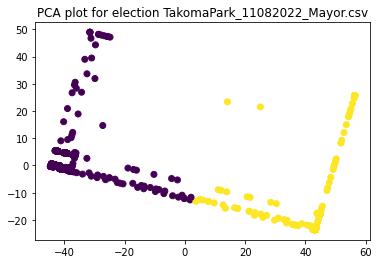

Inter-centroid distance: 89.6472270556203


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'TakomaPark_11082022_Mayor.csv'].copy()

# Convert candidate names to numeric IDs for PCA
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform PCA
pca = PCA(n_components=2)
pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(pca_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the PCA coordinates and color code them by cluster label
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'PCA plot for election TakomaPark_11082022_Mayor.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

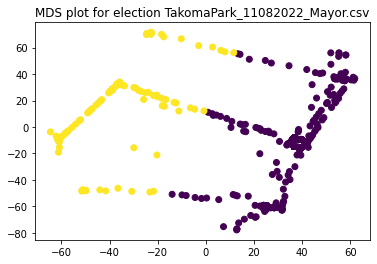

Inter-centroid distance: 89.93371873578063


In [29]:
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'TakomaPark_11082022_Mayor.csv'].copy()

# Convert candidate names to numeric IDs for PCA
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform MDS
mds = MDS(n_components=2)
mds_coordinates = mds.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(mds_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the MDS coordinates and color code them by cluster label
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'MDS plot for election TakomaPark_11082022_Mayor.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

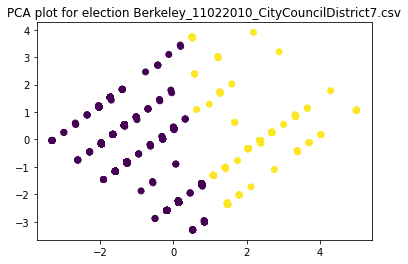

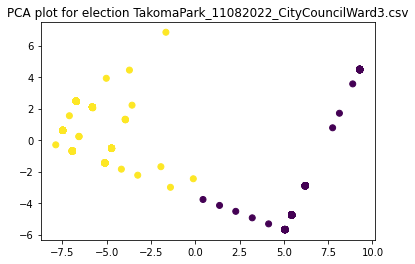

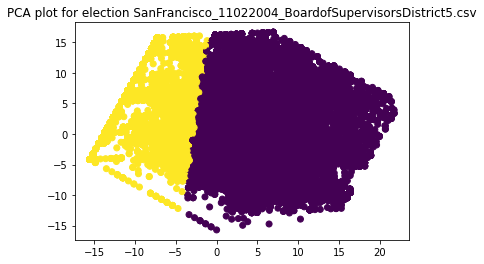

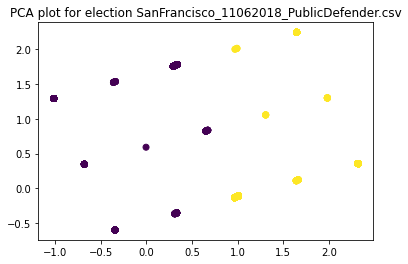

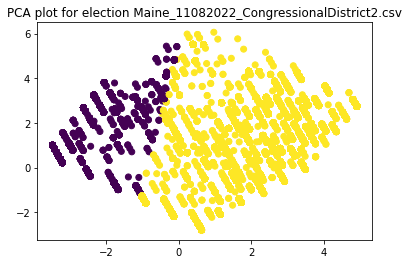

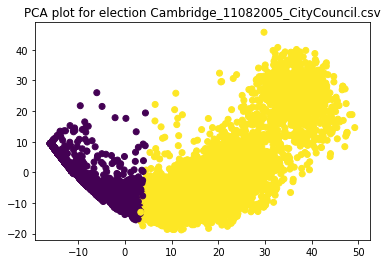

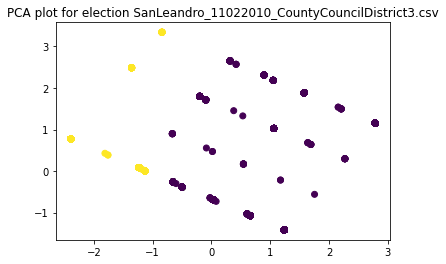

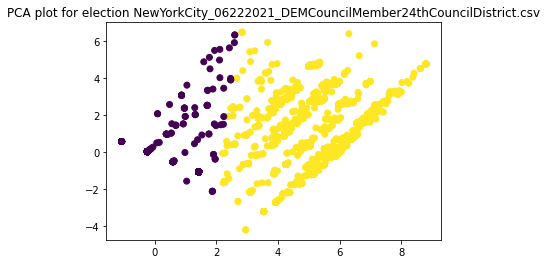

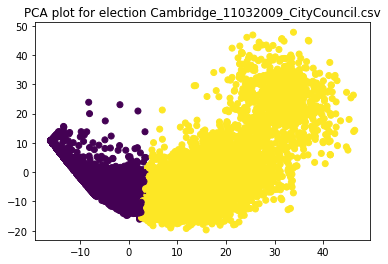

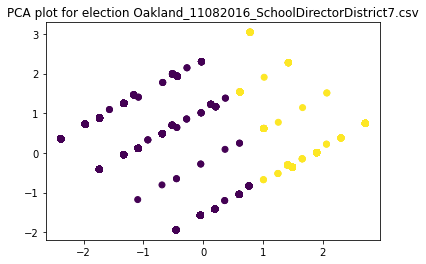

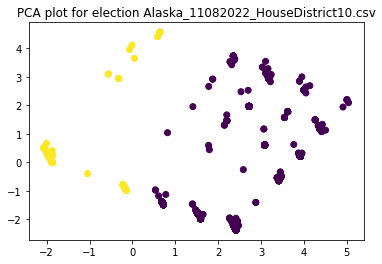

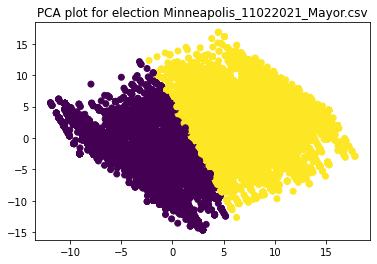

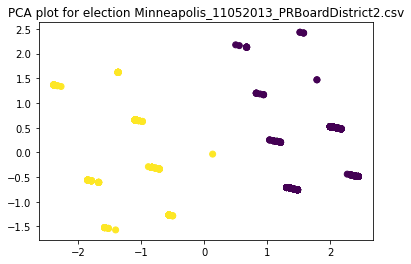

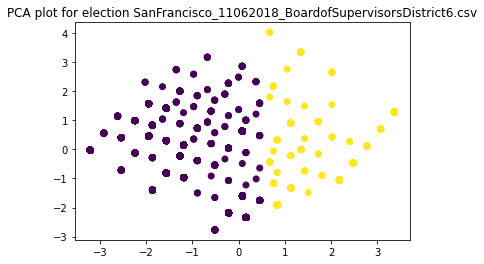

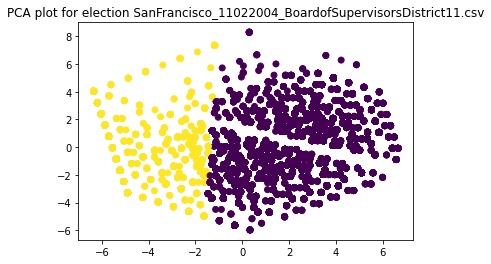

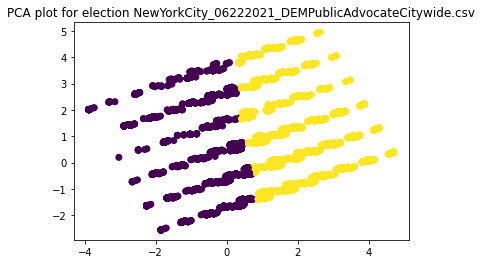

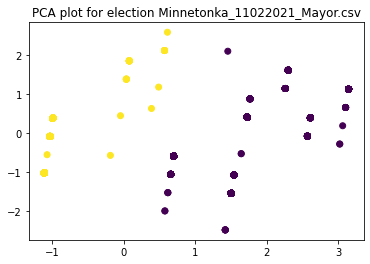

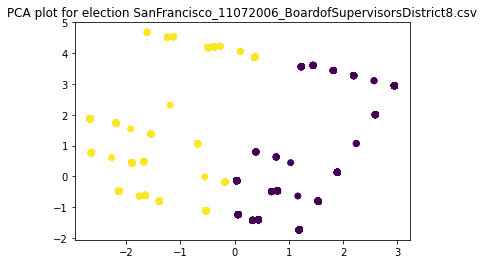

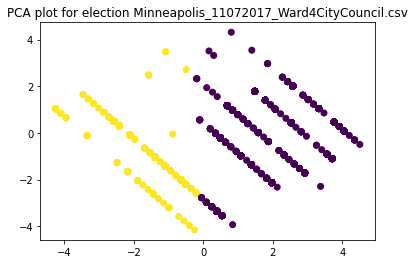

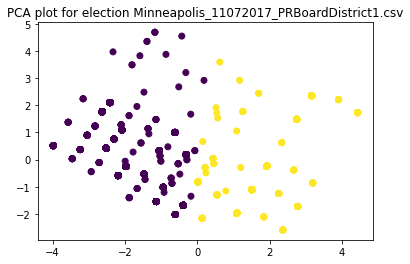

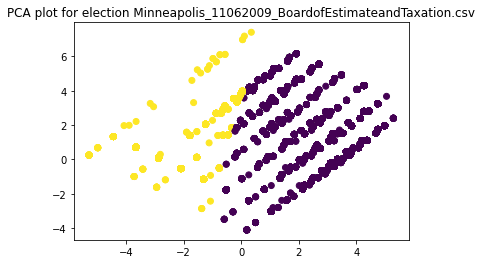

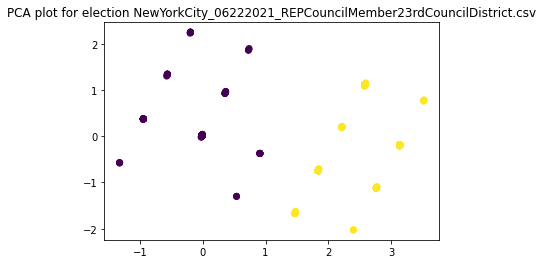

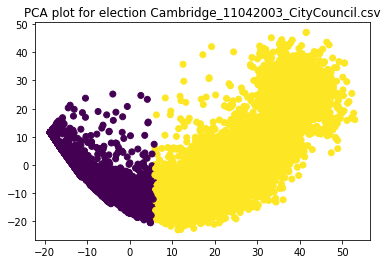

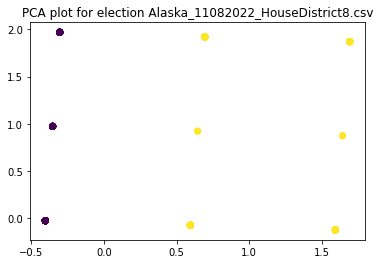

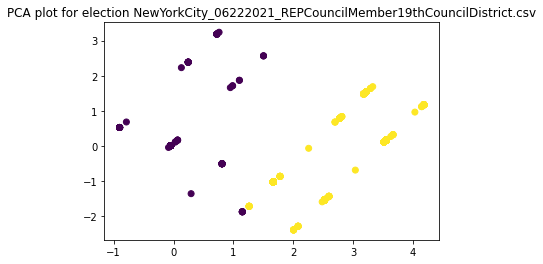

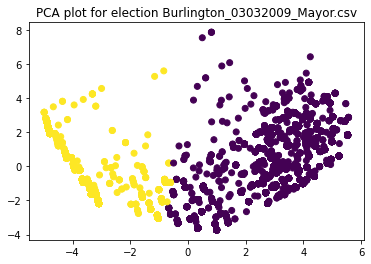

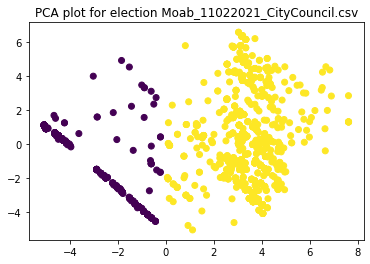

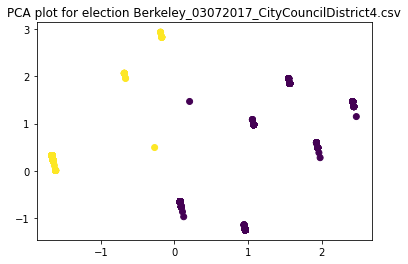

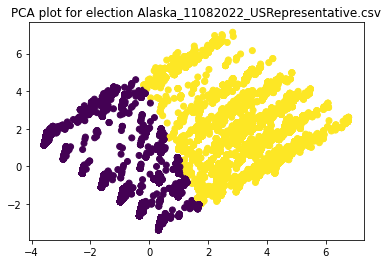

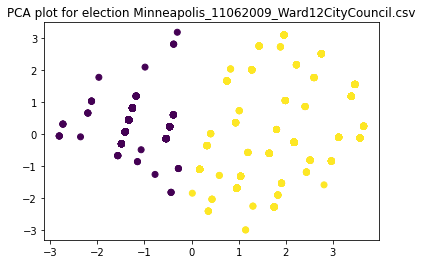

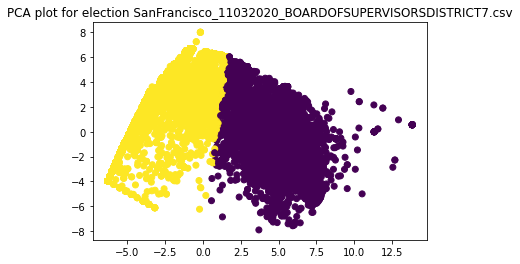

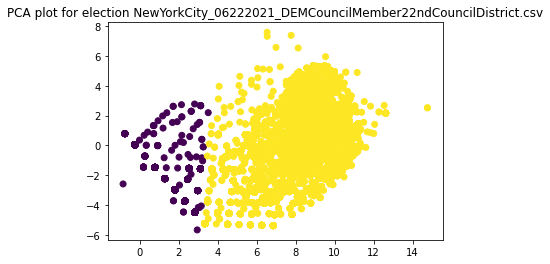

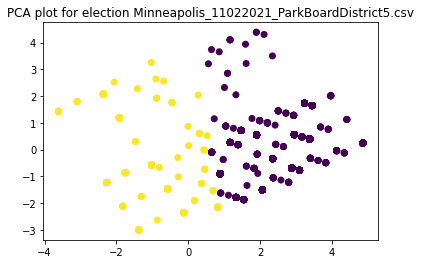

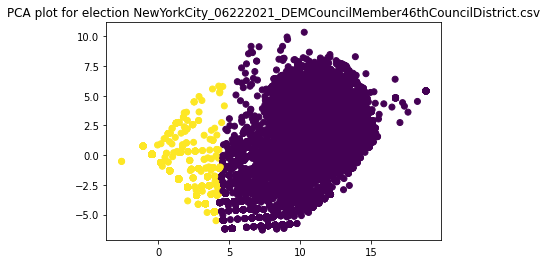

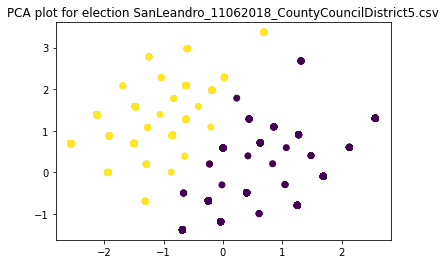

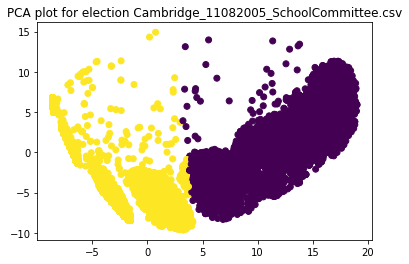

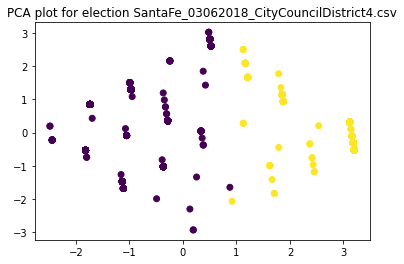

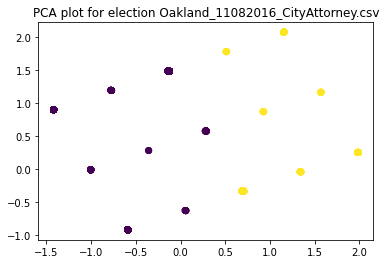

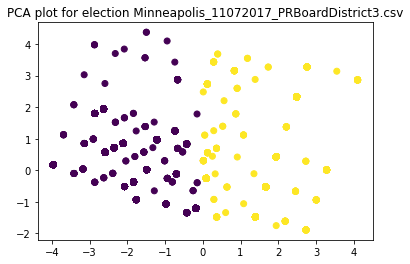

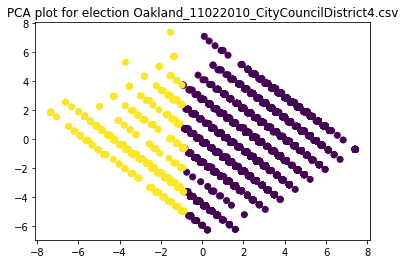

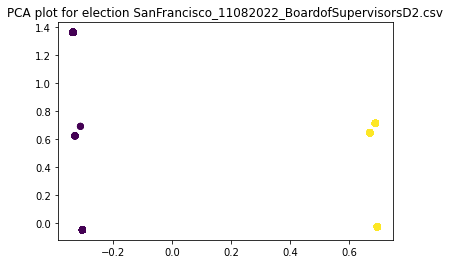

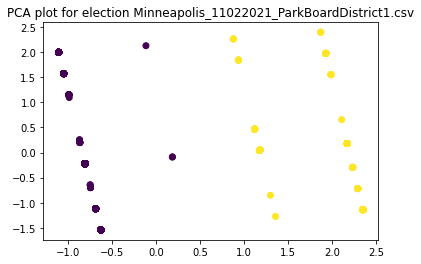

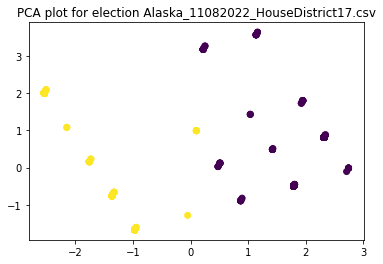

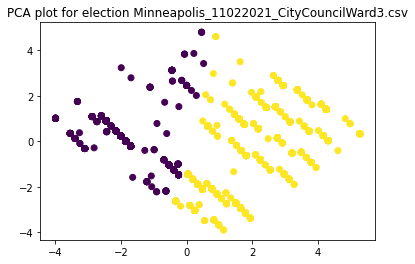

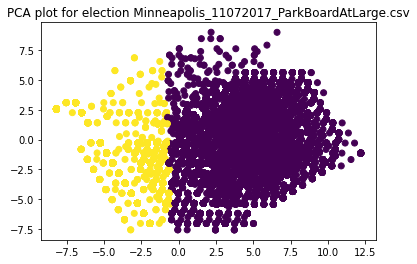

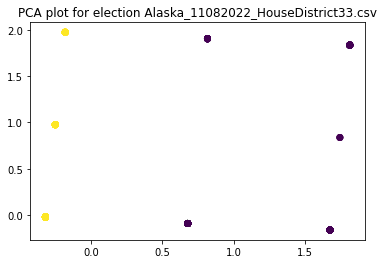

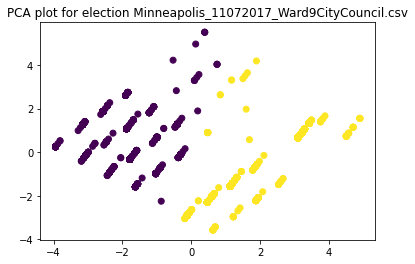

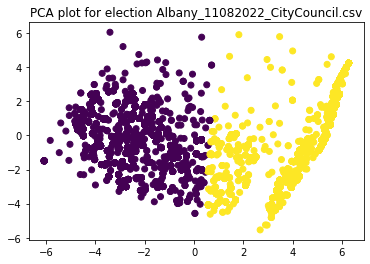

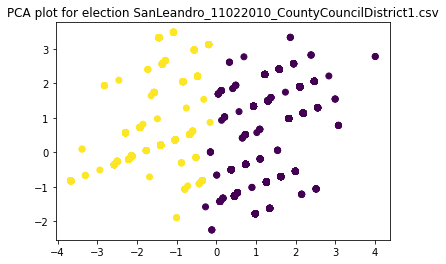

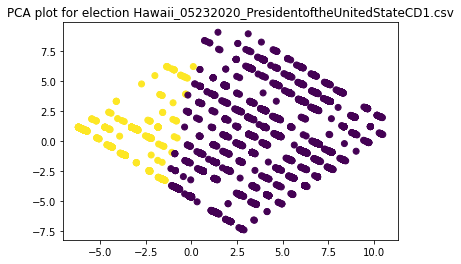

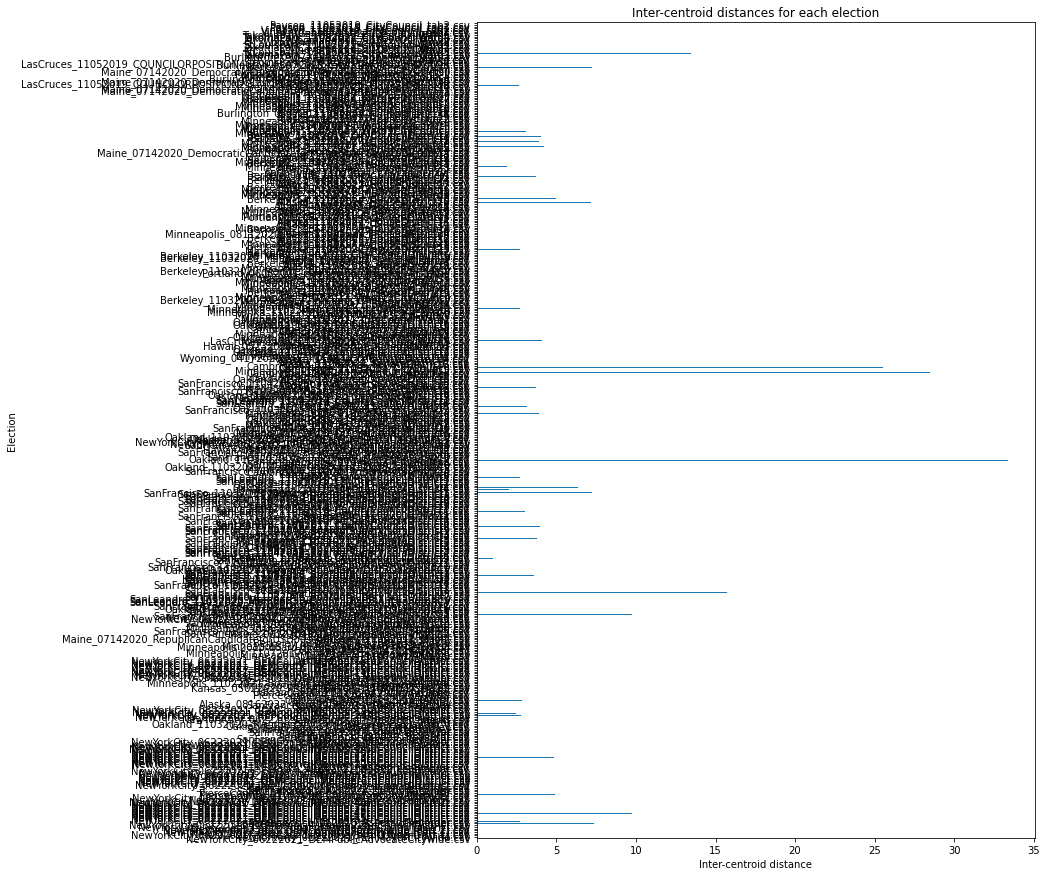

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np

inter_centroid_distances = []

# Number of elections to sample
n_samples = 50

# Randomly sample a subset of the elections
elections_sample = np.random.choice(cast_vote_data['source_file'].unique(), size=n_samples, replace=False)

# Iterate over the sampled elections
for election in elections_sample:
    # Filter DataFrame to include only the current election
    election_df = cast_vote_data[cast_vote_data['source_file'] == election].copy()

    # Convert candidate names to numeric IDs for PCA
    le = LabelEncoder()
    for col in election_df.columns:
        if col.startswith('rank'):
            # Handle missing values by replacing them with a placeholder
            election_df[col] = election_df[col].fillna('Missing')
            election_df[col] = le.fit_transform(election_df[col])

    # Perform PCA
    pca = PCA(n_components=2)
    pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
    kmeans.fit(pca_coordinates)

    # Compute the inter-centroid distance and store it
    centroid1, centroid2 = kmeans.cluster_centers_
    inter_centroid_distance = distance.euclidean(centroid1, centroid2)
    inter_centroid_distances.append(inter_centroid_distance)

    # Plot the PCA coordinates and color code them by cluster label
    plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=kmeans.labels_)
    plt.title(f'PCA plot for election {election}')
    plt.show()

# List of inter-centroid distances for the sampled elections, convert it to a pandas Series for easier manipulation
inter_centroid_distances = pd.Series(inter_centroid_distances, index=elections_sample)

# Reindex the inter_centroid_distances Series to match the order of the ballots_per_election Series
inter_centroid_distances = inter_centroid_distances.reindex(ballots_per_election.index)

# Plot the inter-centroid distances
inter_centroid_distances.plot(kind='barh', figsize=(10, 15))
plt.xlabel('Inter-centroid distance')
plt.ylabel('Election')
plt.title('Inter-centroid distances for each election')
plt.show()